In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from scipy.stats import pearsonr

from Models import Lap_Sim_Funcs as lsf
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

List of F1 Races from the testing period (post Apr 2024)

'Miami Grand Prix', 'Emilia Romagna Grand Prix', 'Monaco Grand Prix', 'Canadian Grand Prix', 'Spanish Grand Prix',

'Austrian Grand Prix', 'British Grand Prix', 'Hungarian Grand Prix', 'Belgian Grand Prix', 'Dutch Grand Prix',

'Italian Grand Prix', 'Azerbaijan Grand Prix', 'Singapore Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix',

'Sao Paulo Grand Prix', 'Las Vegas Grand Prix', 'Qatar Grand Prix', 'Abu Dhabi Grand Prix'

List of Drivers from the testing period (post May 2024)

'ALB', 'ALO', 'BOT', 'GAS', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR', 'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'SAR', 'STR', 'TSU', 'VER', 'ZHO', 'COL', 'BEA', 'LAW'

Modify the inputs in the following cell as per the available data in the testing period

In [2]:
#Input Cell

vw_race = 'United States Grand Prix'   # The race to be viewed
drv_lst = ['VER', 'NOR', 'LEC', 'PIA'] # Driver performances to be viewed (Recommended to have 4 or fewer)

nlaps = 20 #Laps after nlaps are simulated (Default: 20)

In [3]:
# Stage 1 LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 16 
hidden_size = 32
num_layers = 3
output_size = 3 

spd_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Stage 2 LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters
input_size = 23 
hidden_size = 32
num_layers = 3
output_size = 3

pos_model = LSTMModel(input_size, hidden_size, num_layers, output_size)

In [4]:
df = pd.read_csv('Data/F1_Sector_Dataset.csv')

race, qual, drql, drvr = lsf.preprocess_spd_model(df)

test_df = race.loc[race['Date'] >= '2024-05-01'].copy().reset_index(drop = True)

tab = lsf.process_laps('Models/mean_lstm_32_3.pth', spd_model, test_df, qual, nlaps)

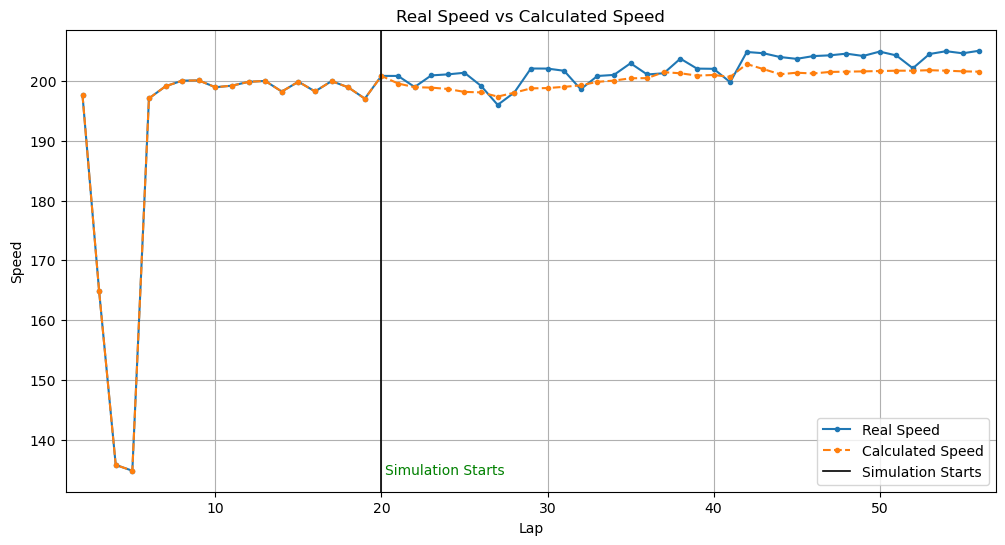

In [5]:
spd_dsp = tab.loc[tab['Race'] == vw_race].reset_index(drop = True)
mean_val = spd_dsp['Err_Lap_Spd'].mean()

plt.figure(figsize=(12, 6))
plt.plot(spd_dsp['Lap'], spd_dsp['Real_Spd'], label='Real Speed', linestyle='-', marker = '.')
plt.plot(spd_dsp['Lap'], spd_dsp['Calc_Spd'], label='Calculated Speed', linestyle='--', marker = '.')
plt.xlabel('Lap')
plt.ylabel('Speed')
plt.title('Real Speed vs Calculated Speed')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, max(spd_dsp['Real_Spd'].min(), spd_dsp['Calc_Spd'].min()), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(spd_dsp['Lap'].min() - 1, spd_dsp['Lap'].max() + 1)

plt.legend()
plt.grid(True)



plt.show()


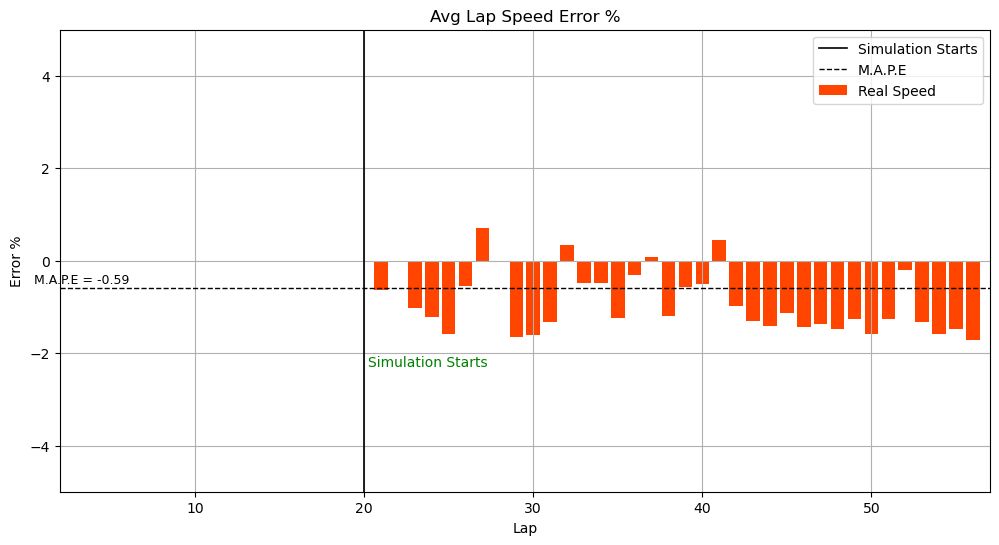

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(spd_dsp['Lap'], spd_dsp['Err_Lap_Spd'], label = 'Real Speed', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error %')
plt.title('Avg Lap Speed Error %')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = mean_val, color='black', linestyle='--', linewidth = 1, label = 'M.A.P.E')

plt.text(x=0.5, y = mean_val + 0.1, s=f'M.A.P.E = {mean_val:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (spd_dsp['Err_Lap_Spd'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(spd_dsp['Lap'].min(), spd_dsp['Lap'].max()+1)
plt.ylim(min(spd_dsp['Err_Lap_Spd'].min() - 1, -5), max(spd_dsp['Err_Lap_Spd'].max() + 1, 5))

plt.legend()
plt.grid(True)

In [7]:
spd_dsp.head()

,Race,Date,Lap,Total,Progress,Life,Drivers,Hards,Softs,Mediums,Inters,Wets,Status_S2,Status_S4,Status_S6,Status_S7,Status_S8,Sec1_P,Sec2_P,Sec3_P,Sec1_T,Sec2_T,Sec3_T,Qual_Sec1_Spd,Qual_Sec2_Spd,Qual_Sec3_Spd,Calc_Spd,Real_Spd,Err_Lap_Spd
0,United States Grand Prix,2024-10-20,2.0,56.0,0.035714,2.052632,19,4.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,236.369417,163.372654,193.104439,236.369417,163.372654,193.104439,259.883543,175.716733,212.683559,197.615503,197.615503,0.0
1,United States Grand Prix,2024-10-20,3.0,56.0,0.053571,3.052632,19,4.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,239.473868,118.840386,136.254537,239.473868,118.840386,136.254537,259.883543,175.716733,212.683559,164.856263,164.856263,0.0
2,United States Grand Prix,2024-10-20,4.0,56.0,0.071429,3.894737,19,4.0,0.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,171.557926,116.929862,118.882106,171.557926,116.929862,118.882106,259.883543,175.716733,212.683559,135.789965,135.789965,0.0
3,United States Grand Prix,2024-10-20,5.0,56.0,0.089286,4.894737,19,4.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,181.667105,107.548865,115.237483,181.667105,107.548865,115.237483,259.883543,175.716733,212.683559,134.817818,134.817818,0.0
4,United States Grand Prix,2024-10-20,6.0,56.0,0.107143,5.894737,19,4.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.725410,160.795962,194.728763,235.725410,160.795962,194.728763,259.883543,175.716733,212.683559,197.083378,197.083378,0.0


In [8]:
drv_race = lsf.preprocess_pos_model(tab, race, qual, drql, drvr)

test_df = drv_race.loc[drv_race['Date'] >= '2024-05-01'].copy().reset_index(drop = True)

prg = lsf.driver_laps('Models/pos_lstm_32_3.pth', pos_model, test_df, nlaps)

In [9]:

pos_dsp = prg.loc[(prg['Race'] == vw_race) & (prg['Driver'].isin(drv_lst))].reset_index(drop = True)

dsp_drvr = 'VER' #Error Metrics for an arbitrarily chosen driver

drv_dsp = prg.loc[(prg['Race'] == vw_race) & (prg['Driver'] == dsp_drvr)].reset_index(drop = True) 

err_sec = drv_dsp['Err_Drv_Spd'].mean()
err_pos = drv_dsp['Err_Position'].mean()


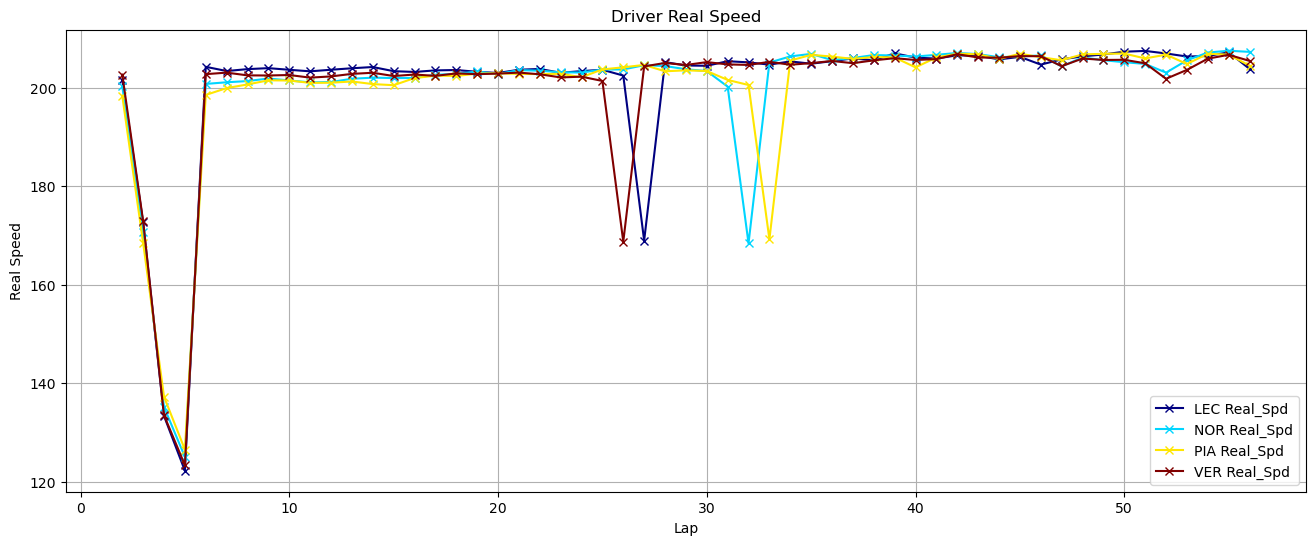

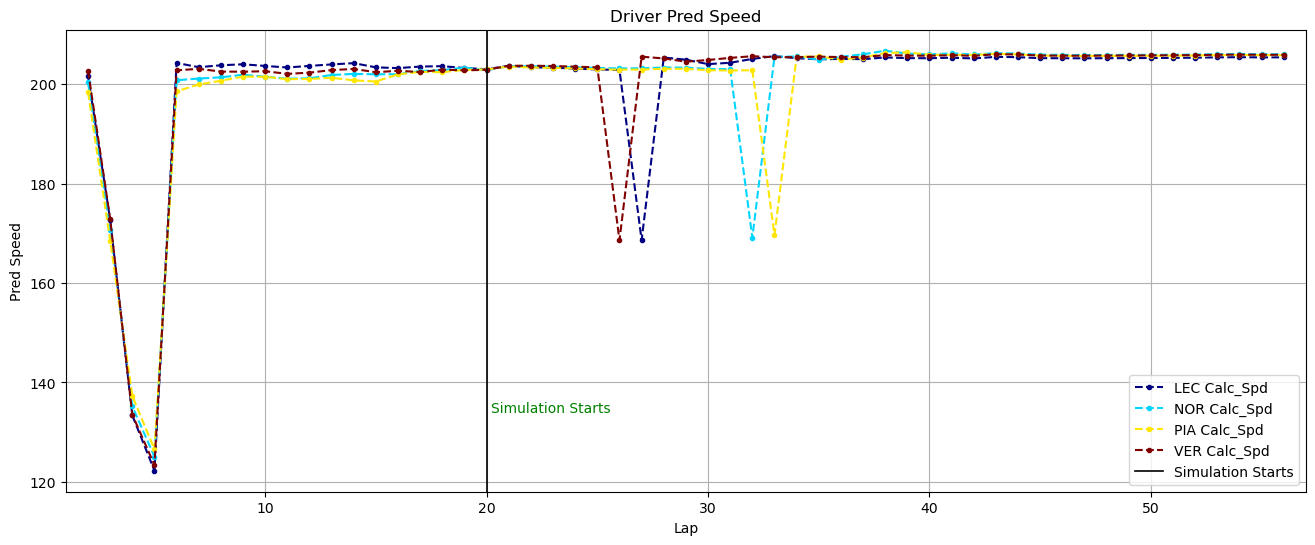

In [10]:
drivers = pos_dsp['Driver'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(drivers)))  # Using a colormap for color assignment

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Drv_Real_Spd'], label=f'{driver} Real_Spd', marker='x', color=color)

plt.title('Driver Real Speed')
plt.xlabel('Lap')
plt.ylabel('Real Speed')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Drv_Calc_Spd'], label=f'{driver} Calc_Spd', marker='.', linestyle='--', color=color)

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, max(spd_dsp['Real_Spd'].min(), spd_dsp['Calc_Spd'].min()), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(spd_dsp['Lap'].min() - 1, spd_dsp['Lap'].max() + 1)

plt.title('Driver Pred Speed')
plt.xlabel('Lap')
plt.ylabel('Pred Speed')
plt.legend()
plt.grid(True)
plt.show()


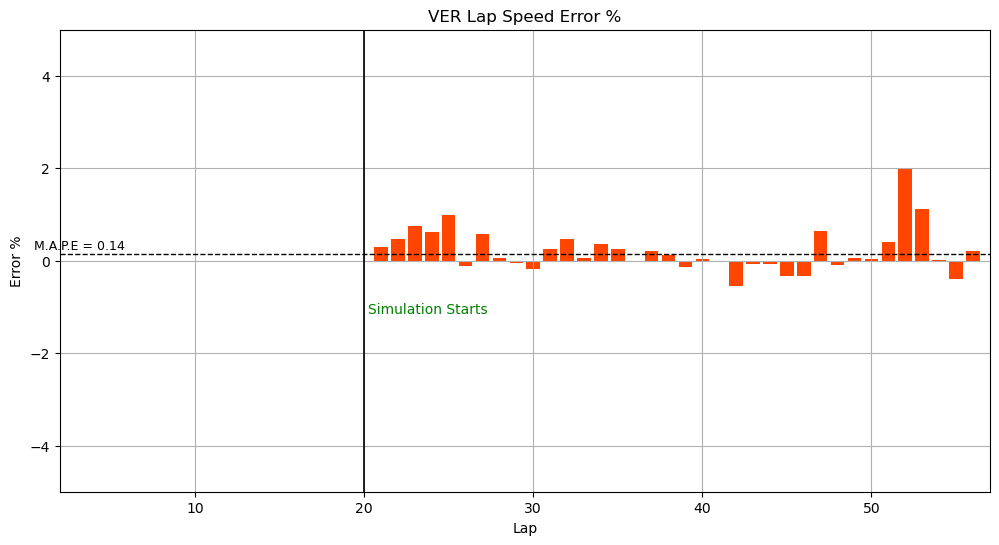

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(drv_dsp['Lap'], drv_dsp['Err_Drv_Spd'], label = 'Real Speed', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error %')
plt.title(dsp_drvr + ' Lap Speed Error %')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = err_sec, color='black', linestyle='--', linewidth = 1, label = 'M.A.P.E')

plt.text(x=0.5, y = err_sec + 0.1, s=f'M.A.P.E = {err_sec:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (drv_dsp['Err_Drv_Spd'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(drv_dsp['Lap'].min(), drv_dsp['Lap'].max()+1)
plt.ylim(min(drv_dsp['Err_Drv_Spd'].min() - 1, -5), max(drv_dsp['Err_Drv_Spd'].max() + 1, 5))

plt.grid(True)

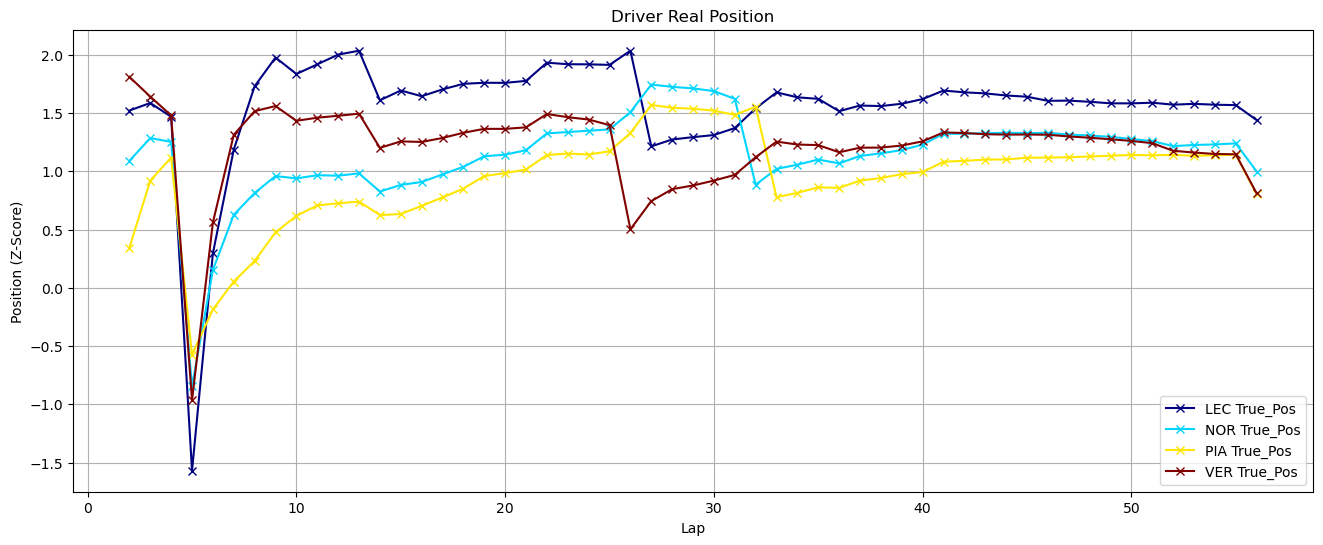

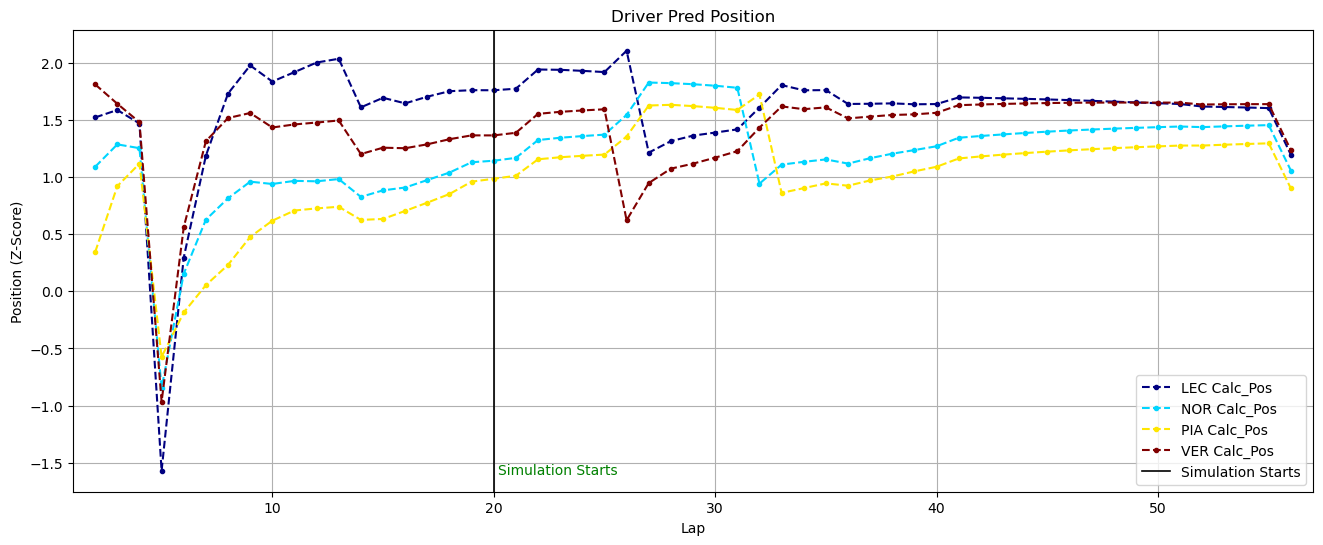

In [12]:
drivers = pos_dsp['Driver'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(drivers)))

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):
    
    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Position_T'], label=f'{driver} True_Pos', marker='x', color=color)

plt.title('Driver Real Position')
plt.xlabel('Lap')
plt.ylabel('Position (Z-Score)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16, 6))

for driver, color in zip(drivers, colors):

    driver_data = pos_dsp[pos_dsp['Driver'] == driver]

    plt.plot(driver_data['Lap'], driver_data['Position_P'], label=f'{driver} Calc_Pos', marker='.', linestyle='--', color=color)

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.text(nlaps + 0.2, pos_dsp['Position_P'].min(), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')

plt.xlim(pos_dsp['Lap'].min() - 1, pos_dsp['Lap'].max() + 1)
plt.title('Driver Pred Position')
plt.xlabel('Lap')
plt.ylabel('Position (Z-Score)')
plt.legend()
plt.grid()
plt.show()

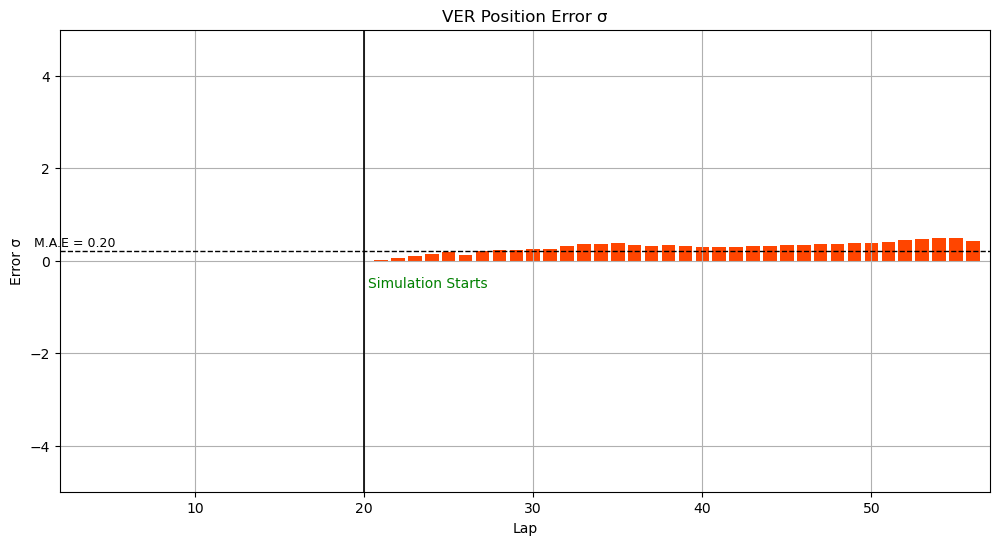

In [13]:
plt.figure(figsize=(12, 6))
plt.bar(drv_dsp['Lap'], drv_dsp['Err_Position'], label = 'Position Error', color = 'orangered')


plt.xlabel('Lap')
plt.ylabel('Error σ')
plt.title(dsp_drvr + ' Position Error σ')

plt.axvline(x=nlaps, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = err_pos, color='black', linestyle='--', linewidth = 1, label = 'M.A.E')

plt.text(x=0.5, y = err_pos + 0.1, s=f'M.A.E = {err_pos:.2f}', color='black', fontsize=9)

plt.text(nlaps + 0.2, (drv_dsp['Err_Position'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(drv_dsp['Lap'].min(), drv_dsp['Lap'].max()+1)
plt.ylim(min(drv_dsp['Err_Position'].min() - 1, -5), max(drv_dsp['Err_Position'].max() + 1, 5))

plt.grid(True)

In [14]:
std = lsf.rank_drivers(prg)
rce_std = std.loc[std['Race'] == vw_race].reset_index(drop = True)

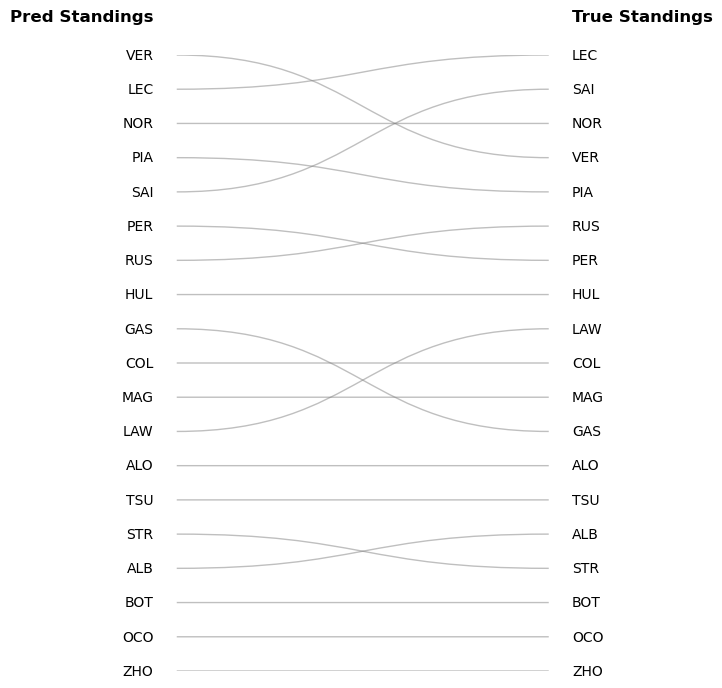

In [15]:
# Set up the figure
fig, ax = plt.subplots(figsize=(6, 8))
ax.axis('off')

# Positions for the left and right sides
x_left = 0.1
x_right = 0.9
n_drivers = len(rce_std)

# Sort drivers according to standings
df_left = rce_std.sort_values(by = ['Standing_P'], ascending = False).reset_index(drop=True)
df_left['y_left'] = np.linspace(0, 1, n_drivers)
df_right = rce_std.sort_values(by = ['Standing_T'], ascending = False).reset_index(drop=True)
df_right['y_right'] = np.linspace(0, 1, n_drivers)

# Map drivers to their positions
driver_positions = {}
for idx, row in rce_std.iterrows():
    driver = row['Driver']
    y_left = df_left[df_left['Driver'] == driver]['y_left'].values[0]
    y_right = df_right[df_right['Driver'] == driver]['y_right'].values[0]
    driver_positions[driver] = {'y_left': y_left, 'y_right': y_right}

# Plot driver names and draw curved lines
for driver, pos in driver_positions.items():
    y_left = pos['y_left']
    y_right = pos['y_right']
    # Plot driver names
    ax.text(x_left - 0.05, y_left, driver, ha='right', va='center')
    ax.text(x_right + 0.05, y_right, driver, ha='left', va='center')

    # Draw a curved line between left and right positions
    verts = [
        (x_left, y_left),
        ((x_left + x_right) / 2, y_left),
        ((x_left + x_right) / 2, y_right),
        (x_right, y_right),
    ]
    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor='gray', alpha=0.5)
    ax.add_patch(patch)

ax.text(x_left - 0.05, 1.05, 'Pred Standings', ha='right', va='bottom', fontsize=12, fontweight='bold')
ax.text(x_right + 0.05, 1.05, 'True Standings', ha='left', va='bottom', fontsize=12, fontweight='bold')

plt.show()

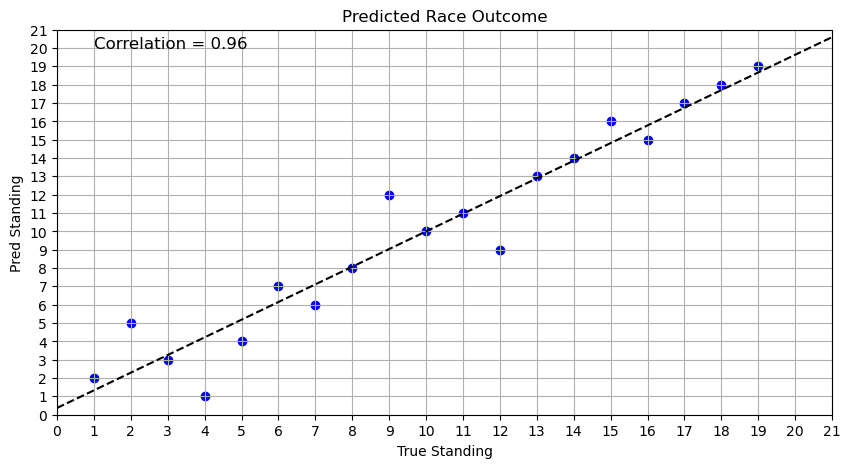

In [16]:
dsp_rce = rce_std.loc[rce_std['Race'] == vw_race].reset_index(drop = True)

# 1. Extract x and y
x = dsp_rce['Standing_T']
y = dsp_rce['Standing_P']

# 2. Calculate Pearson correlation coefficient
corr_coef, _ = pearsonr(x, y)

# 3. Create the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='blue', label='Data Points')

# 4. Fit a simple linear regression line: y = slope*x + intercept
slope, intercept = np.polyfit(x, y, 1)

# 5. Generate line points for plotting the regression line
#    Sort x so the line will be plotted cleanly from left to right
x_line = np.linspace(0, 21, 100)  # or you can do np.sort(x) if you prefer
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='black', linestyle='--', label='Regression Line')

# 6. Label axes, title, etc.
plt.xlabel('True Standing')
plt.ylabel('Pred Standing')
plt.title('Predicted Race Outcome')

# 7. Display Pearson correlation coefficient on the plot
#    Adjust the coordinates (x_text, y_text) as desired
x_text = 1   # Example: near the left side
y_text = 20  # near the top
plt.text(x_text, y_text, f"Correlation = {corr_coef:.2f}", fontsize=12, color='black')

# 8. Set axis limits and integer ticks from 0 to 21
plt.xlim(0, 21)
plt.ylim(0, 21)
plt.xticks(range(0, 22))
plt.yticks(range(0, 22))
plt.grid()
plt.show()